In [1]:
# Importing Libraries
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from scipy.optimize import minimize
from qiskit.visualization import plot_histogram
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Gives the value of vertex cover function for input bitstring
def max_wt(x, w, G):
    
    edges = list(G.edges())
    nodeA = []
    nodeB = []
    sumv=[]
    
    for i in range(len(x)):
        if x[i] == 1:
            nodeA.append(edges[i][0])
            nodeB.append(edges[i][1])
            sumv.append(sum(edges[i]))
    
    A = len(list(set(nodeA)))
    B = len(list(set(nodeB)))
    sumv = len(list(set(sumv)))
    
    obj = 0
    k = len(G.nodes())
    a=[i for i in x]
    x = [eval(i) for i in a]
    if sum(x) == int(k):
        if A == k and B == k:
            if sumv >= k-1:
                for i in range(len(x)):
                    obj = obj - x[i]*w[i]
            
    return obj


# Computes Expectation Value
def compute_expectation(counts,w, G):
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        obj = max_wt(bitstring,w, G)
        avg += obj * count
        sum_count += count
    return avg/sum_count

In [3]:
def basic_qaoa(G, theta,w) :

    # Basic QAOA circuit for Max weight cycle Problem
    def create_qaoa_circ(G, theta):
    
        # Division of input array Theta
        nqubits = len(G.edges())
        nlayers = len(theta)//2 
        beta = theta[:nlayers]
        edges=list(G.edges())
        gamma = theta[nlayers:]

        qc = QuantumCircuit(nqubits)

        # initial_state
        qc.h(range(nqubits))

        for irep in range(nlayers):
        
            # problem unitary
            for i in range(nqubits):
                qc.rz(2 * beta[irep], i)
            for i in range(0,nqubits):
                for j in range(0,nqubits):
                    if j>i:
                        if (edges[i][0] in edges[j] ) or  (edges[i][1] in edges[j]):
                            qc.rzz(2 * beta[irep],i,j)
            qc.barrier()
            
            # mixer unitary
            for qubit in range(nqubits):
                qc.rx(2 * gamma[irep], qubit)

        qc.measure_all()
        return qc

    def get_expectation_QAOA(graph, shots=512):
        backend = Aer.get_backend('qasm_simulator')
        backend.shots = shots
        def execute_circ(theta):
            qc = create_qaoa_circ(graph, theta)
            counts = backend.run(qc, seed_simulator=10,
                                 nshots=512).result().get_counts()
            return compute_expectation(counts,w, graph)
        return execute_circ
    
    global qc_basic
    qc_basic = create_qaoa_circ(G, theta)
    
    # Optimizing Parameters for Basic QAOA
    expectation = get_expectation_QAOA(G)
    global res_basic
    res_basic = minimize(expectation, theta, method='COBYLA')

    
    backend = Aer.get_backend('aer_simulator')
    backend.shots = 512

    qc_res = create_qaoa_circ(G, res_basic.x)
    counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
    return counts

In [4]:
# Multi-Angle QAOA Function which returns counts
def multi_angle_qaoa(G, theta,w) :
    
    # Multi-Angle QAOA circuit for Minimum Vertex Cover Problem
    def create_maqaoa_circ(G, theta): 
    
        nqubits = len(G.edges()) 
        qc = QuantumCircuit(nqubits)
        clauses = len(G.edges())
        nlayers = len(theta)//((nqubits*2)+clauses)
        beta = np.reshape(theta[:nlayers*nqubits], (nlayers,nqubits))
        gamma = np.reshape(theta[nlayers*nqubits:], (nlayers,nqubits+clauses))
    
        for m in range(nqubits):
            qc.h(m)
    
        for irep in range(nlayers):
            k=0
        
            # problem unitary
            # problem unitary
            for i in range(nqubits):
                qc.rz(2 * beta[irep,k], i)
            for i in range(0,nqubits):
                for j in range(0,nqubits):
                    if j>i:
                        if (edges[i][0] in edges[j] ) or  (edges[i][1] in edges[j]):
                            qc.rzz(2*beta[irep,k],i,j)
            qc.barrier()
        
        
            # mixer unitary
            for i in range(nqubits):
                qc.rx(2 * gamma[irep,i], i)
        
        qc.measure_all()
        return qc

    def get_expectation_MAQAOA(G, shots=512):
        backend = Aer.get_backend('qasm_simulator')
        backend.shots = shots
    
        def execute_circ(theta):
        
            qc = create_maqaoa_circ(G, theta)
            counts = backend.run(qc, seed_simulator=10, nshots=512).result().get_counts()
            return compute_expectation(counts, w, G)
    
        return execute_circ
    
    global qc_multi
    qc_multi = create_maqaoa_circ(G, theta)
    
    # Optimizing Parameters for Basic QAOA
    expectation = get_expectation_MAQAOA(G)
    global res_multi
    res_multi = minimize(expectation, theta, method='COBYLA')

    
    backend = Aer.get_backend('aer_simulator')
    backend.shots = 512

    qc_res = create_maqaoa_circ(G, res_multi.x)
    counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
    return counts

Number of Nodes =  4
Number of Edges =  4


[0.55, 0.57, 0.45, 0.45]

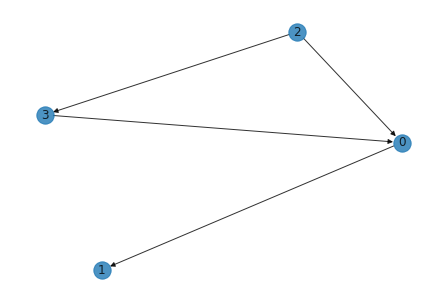

In [10]:
# Generating a Graph
import networkx as nx

edges = [[0,1,0.55], [2,0,0.57], [2,3,0.45],[3,0,0.45]]
weights = []
G = nx.DiGraph()

for i in range(len(edges)):
    G.add_edge(edges[i][0], edges[i][1], weight = edges[i][2])
    weights.append(edges[i][2])

print("Number of Nodes = ", len(G.nodes()))
print("Number of Edges = ", len(G.edges()))
nx.draw(G, with_labels=True, alpha=0.8)
weights

In [6]:
# Adding Parameters

# Basic QAOA

# n = number of layers to generate
beta = [1,1,2,3,4,1,1,3,1,3,0,0,0,0,0] # [Beta(n)]
gamma = [5,8,6,2,8,9,2,1,5,7,0,0,0,0,0] # [Gamma(n)]
theta_basic = np.concatenate((beta, gamma))


# Multi-Angle QAOA

beta = np.array([[5,4,7,5,3],[5,4,7,5,3]]) 
# Length = the number of qubits, Arrays = Number of Layers
gamma = np.array([[3,6,5,3,5,1,1],[3,6,5,3,5,1,1]]) 
# Length = the number of (edges+qubits), Arrays = Number of Layers

theta_multi = np.concatenate((beta.flatten(), gamma.flatten()))

Basic QAOA :  0.0


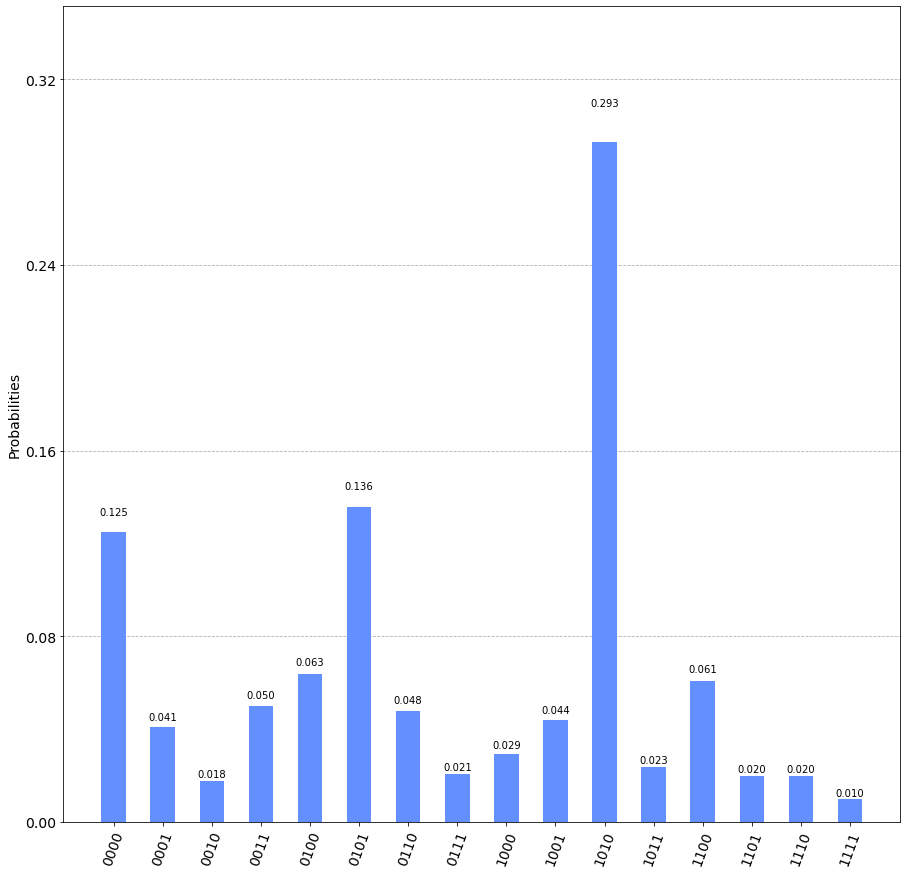

In [7]:
# Visualizing the Probability Distribution - Basic QAOA
counts = basic_qaoa(G, theta_basic,weights)
print("Basic QAOA : ", res_basic.fun)
plot_histogram(counts, figsize = (15,15))

Multi-Angle QAOA :  0.0


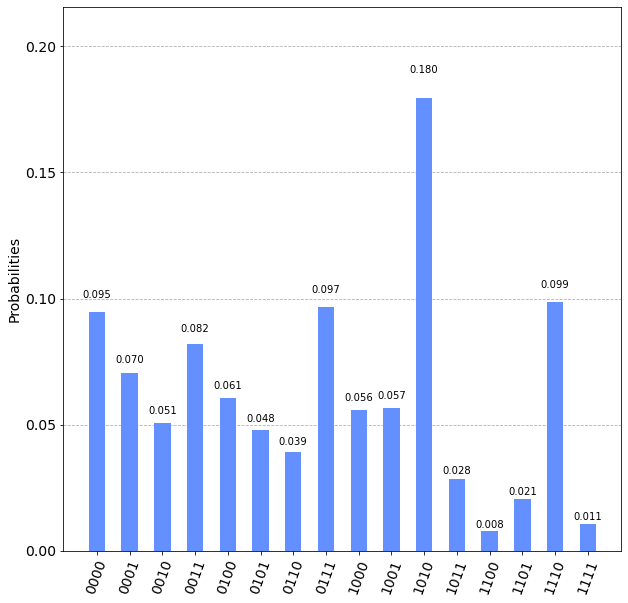

In [8]:
# Visualizing the Probability Distribution - Multi QAOA
counts_multi = multi_angle_qaoa(G, theta_multi,weights)
print("Multi-Angle QAOA : ", res_multi.fun)
plot_histogram(counts_multi, figsize = (10,10))